In [ ]:
import sys
import os
# Detect if running in Google Colab
if "google.colab" in sys.modules:
    !pip install ultralytics

    # make utils dir
    os.makedirs("/content/src/utils", exist_ok=True)
    !wget -O /content/src/utils/utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/utils.py
    !wget -O /content/src/utils/preprocess_utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/preprocess_utils.py
    sys.path.append("/content/src")

    # make scripts dir
    os.makedirs("/content/src/scripts", exist_ok=True)
    !wget -O /content/src/scripts/inference.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/scripts/inference.py

    # import config from git
    !wget -O /content/config.yaml https://raw.githubusercontent.com/jayyang17/pool_management_system/main/config.yaml

    # get training data from s3
    os.makedirs("/content/artifact", exist_ok=True)
    !wget aws s3 cp 'https://poolmanagementsystem.s3.ap-southeast-1.amazonaws.com/raw_data/data.zip' -O /content/artifact/data.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Normal import (works in both local & Colab)
import ultralytics
from src.utils.utils import unzip_file, read_yaml, write_yaml, save_model, zip_model
from src.utils.preprocess_utils import process_dataset, augment_images, balance_dataset,create_yolo_data_yaml, split_train_val


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Configurations

In [3]:
# config
config = read_yaml('./config.yaml')

In [4]:
import yaml

# Label studio data
RAW_DATA_PATH = config["RAW_DATA_PATH"]

# PATH CONFIGURATIONS
ARTIFACT_DIR      = config["ARTIFACT_DIR"]
ORIGINAL_PATH     = config["ORIGINAL_PATH"]

# Original data paths (from Label Studio)
ORIGINAL_IMG_DIR  = config["ORIGINAL_IMG_DIR"]    # Images from Label Studio
YOLO_LABELS_DIR   = config["YOLO_LABELS_DIR"]     # YOLO labels from Label Studio

# Resized data paths (before augmentation)
RESIZED_IMG_DIR   = config["RESIZED_IMG_DIR"]     # Resized images
RESIZED_LABELS_DIR = config["RESIZED_LABELS_DIR"]    # Updated YOLO labels

# Augmented data paths
AUGMENTED_IMG_DIR   = config["AUGMENTED_IMG_DIR"]     # Augmented images
AUGMENTED_LABELS_DIR = config["AUGMENTED_LABELS_DIR"]   # Augmented YOLO labels

# Target training directories
TRAINING_IMG_DIR   = config["TRAINING_IMG_DIR"]
TRAINING_LABELS_DIR = config["TRAINING_LABELS_DIR"]

# Other paths
SOURCE_TRAIN_DIR  = config["SOURCE_TRAIN_DIR"]
MODEL_OUTPUT_DIR  = config["MODEL_OUTPUT_DIR"]
ZIP_MODEL_PATH    = config["ZIP_MODEL_PATH"]
CLASSES_TXT_PATH  = config["CLASSES_TXT_PATH"]
DATA_YAML_PATH    = config["MODEL"]["DATA_YAML_PATH"]

# data path for model training
# Determine the base path dynamically, to avoid changing the env
if os.path.exists('/content'):
    # Set the dataset path for Colab
    DATA_PATH = '/content/data'
else:
    # For local
    DATA_PATH = os.path.join(os.getcwd(), 'data')




# Upload Dataset and prepare training data

In [5]:
# unzip the zip file generated from label-studio into the output dir
unzip_file(RAW_DATA_PATH,ORIGINAL_PATH)

Successfully extracted ./artifact/data.zip to ./artifact/original_data


# Preprocess

In [6]:
# resize the image
process_dataset(ORIGINAL_IMG_DIR, RESIZED_IMG_DIR, RESIZED_LABELS_DIR, YOLO_LABELS_DIR)

Processed pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Processed train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Processed fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg
Processed train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Processed pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Processed train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Processed train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Processed pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg
Processed train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg
Processed pinterest-04_jpg.rf.3e7d9f90986b4dccb7cabed2f1023bf1.jpg
Processed pinterest-12_jpg.rf.e7c79282f4403830711b1a09433dcf46.jpg
Processed pinterest-15_jpg.rf.5105a1f644e876833001fa4a6edb5c5a.jpg
Processed pinterest-07_jpg.rf.df6d713578885ff1eb07fbca5929e692.jpg
Processed pinterest-11_jpg.rf.98389ab55b22740e1bd60b98a7311ad4.jpg
Processed pinterest-14_jpg.rf.19dc64f82b4406ee0f2e31b4cccde8df.jpg
Processed train-06_

In [7]:
augment_images(RESIZED_IMG_DIR, RESIZED_LABELS_DIR, AUGMENTED_IMG_DIR, AUGMENTED_LABELS_DIR)

Augmented: pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg --> aug_pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Augmented: train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg --> aug_train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Augmented: fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg --> aug_fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg
Augmented: train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg --> aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Augmented: pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg --> aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Augmented: train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg --> aug_train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Augmented: train-07_png.rf.588b8660db71799422e9f255221198f9.jpg --> aug_train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Augmented: pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg --> aug_pinterest-01_jpg.rf.ad8480119674c

In [8]:
# Data splitting ratios
DATA_SPLIT = config["DATA_SPLIT"]
IMG_BALANCE_RATIO = DATA_SPLIT["img_balance_ratio"]

balance_dataset(
    RESIZED_IMG_DIR,
    RESIZED_LABELS_DIR,
    AUGMENTED_IMG_DIR,
    AUGMENTED_LABELS_DIR,
    TRAINING_IMG_DIR,
    TRAINING_LABELS_DIR,
    ratio_original=IMG_BALANCE_RATIO,
    total_samples=None)


Balanced dataset created with 37 original and 37 augmented images.


## split training and validation

In [9]:
# split training and validation images
TRAIN_RATIO       = DATA_SPLIT["train_ratio"]
split_train_val(TRAINING_IMG_DIR, TRAINING_LABELS_DIR, TRAIN_RATIO)

Found 74 images and 74 labels.
Splitting data: 59 for training, 15 for validation.
Data split complete! Check the 'train/' and 'validation/' folders.


In [10]:
# create the data.yaml file
create_yolo_data_yaml(DATA_PATH, CLASSES_TXT_PATH, DATA_YAML_PATH)

# check the data.yaml file
read_yaml(DATA_YAML_PATH)

YAML file created at ./data.yaml


{'path': '/content/data',
 'train': 'train/images',
 'val': 'validation/images',
 'nc': 2,
 'names': ['occupied', 'empty']}

# Model Training

In [11]:
from ultralytics import YOLO

# Define training parameters
PRETRAIN_MODEL = "yolov8m.pt"       # Pretrained model
DATA_YAML_PATH = "data.yaml"        # Path to data config
IMG_SIZE = 640                      # Standard YOLO input size
EPOCHS = 100                         # Reduce to prevent overfitting
BATCH_SIZE = 16                     # Increase if GPU allows
LR0 = 0.0005                        # Lower LR for more stable training
WEIGHT_DECAY = 0.0001               # Reduce overfitting risk
PATIENCE = 20                       # Keep early stopping but lower patience

# Load YOLO model
model = YOLO(PRETRAIN_MODEL)

# Start training with optimized settings
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LR0,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)

print("Training complete!")


100%|██████████| 49.7M/49.7M [00:00<00:00, 189MB/s]


Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 85.2MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1797.12it/s]

train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/validation/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 1908.24it/s]

val: New cache created: /content/data/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.15G      2.578      3.745      1.967        318        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         15        228     0.0645     0.0611     0.0339     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.19G      2.439      3.203      1.828        237        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         15        228      0.164       0.29       0.17     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.35G      2.151       2.17      1.618        135        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         15        228      0.204      0.483      0.319      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.33G      1.991      1.934      1.502        256        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         15        228      0.771      0.228      0.308      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.35G      1.924      1.788      1.499        252        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         15        228      0.273      0.243      0.299      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.17G      1.872      1.767       1.48        200        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         15        228      0.202      0.522      0.214     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.18G        1.8      1.598       1.42        223        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         15        228      0.283      0.469      0.325      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.23G      1.856      1.628      1.457        291        640: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         15        228      0.233      0.342      0.285      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.16G      1.832      1.556       1.44        290        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         15        228      0.328      0.447      0.305      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.42G      1.797      1.575      1.442        240        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         15        228      0.276      0.337      0.305      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       6.4G      1.702      1.406      1.391        206        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         15        228      0.229      0.511       0.22     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       6.4G      1.719      1.519      1.376        230        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         15        228      0.108      0.372     0.0916     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.18G      1.705      1.409      1.411        189        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         15        228      0.287      0.288      0.235      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.17G       1.68      1.333      1.395        264        640: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        228      0.276      0.311      0.236      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.17G       1.64       1.37      1.404        213        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         15        228      0.421      0.311      0.323      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.33G      1.663      1.391      1.354        281        640: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        228      0.391      0.455      0.417      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.45G      1.584      1.307      1.345        180        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         15        228       0.49      0.486      0.525      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.36G      1.686      1.344        1.4        164        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         15        228      0.501       0.56      0.555      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.34G      1.672      1.291      1.372        288        640: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        228      0.547       0.48      0.519       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.22G       1.59      1.309      1.368        218        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         15        228      0.507      0.382      0.375      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.22G      1.683      1.297      1.363        187        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         15        228      0.455       0.57      0.434      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.25G      1.544      1.294      1.369        225        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         15        228      0.491      0.565       0.52      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.34G      1.558      1.153      1.293        291        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        228      0.547      0.427      0.473      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.26G      1.537      1.202       1.34        202        640: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        228      0.565      0.504       0.51       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.26G      1.542      1.192      1.347        185        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         15        228      0.455      0.471      0.397      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.44G      1.752      1.333      1.374        169        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        228      0.479      0.539      0.486      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.37G      1.585       1.21      1.285        224        640: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         15        228      0.494       0.53      0.495      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.32G       1.58      1.245      1.365        218        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         15        228       0.47      0.595      0.527       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.31G      1.597      1.162      1.323        241        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        228      0.623      0.562      0.595      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.37G      1.528      1.134      1.284        205        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         15        228      0.601      0.621      0.628        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.33G      1.477      1.066      1.286        204        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         15        228       0.66      0.686      0.692      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.36G      1.502      1.139      1.285        224        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         15        228      0.632      0.635      0.642      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.31G      1.467      1.014      1.281        247        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         15        228      0.586      0.633       0.62      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.26G      1.465      1.125      1.315        259        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        228      0.555      0.652      0.637      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.27G      1.403      1.099      1.246        170        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         15        228      0.628      0.706      0.682      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.32G      1.382      1.004      1.249        190        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         15        228      0.716      0.638      0.685      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.34G      1.358      1.061       1.26        187        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         15        228      0.704      0.702      0.711      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.25G      1.419      1.053      1.289        181        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        228      0.773      0.669      0.732      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.43G      1.346     0.9794      1.212        320        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         15        228      0.716       0.74      0.758      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.34G      1.408      1.028       1.27        220        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        228      0.731      0.717      0.775      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.26G       1.32     0.9468      1.274        198        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         15        228      0.756      0.666      0.764      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.28G      1.386     0.9679      1.194        260        640: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         15        228      0.686      0.671      0.742      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.41G      1.361      1.036       1.24        247        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        228      0.712      0.707      0.717      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.26G      1.294     0.8972      1.189        289        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         15        228       0.74      0.694      0.712      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.35G       1.34     0.9268       1.21        164        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        228      0.739      0.725      0.753      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.26G      1.302     0.9115      1.213        169        640: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         15        228       0.69      0.768      0.774       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.46G      1.273     0.8595      1.156        281        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        228      0.708      0.763      0.801      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.31G      1.271     0.9011      1.184        200        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         15        228      0.764       0.75      0.809      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.3G      1.232     0.8507       1.14        251        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         15        228      0.756      0.749      0.813       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.32G      1.209     0.8434      1.103        338        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         15        228      0.753      0.754      0.824      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.07G      1.236     0.8537      1.152        295        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         15        228      0.789      0.759      0.831      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.42G      1.232     0.7986      1.111        328        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        228      0.759      0.747      0.828      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.31G      1.194     0.8287       1.13        201        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        228      0.775      0.794      0.843       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.35G      1.255     0.8397      1.136        225        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         15        228      0.829      0.786       0.86      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.35G      1.188     0.7846      1.152        263        640: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        228      0.824      0.764      0.849      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.37G      1.247     0.8344      1.164        179        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        228      0.871      0.711      0.833       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.3G      1.094     0.7528       1.09        185        640: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         15        228      0.894      0.689      0.841      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.31G      1.136     0.7532      1.094        287        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         15        228      0.835       0.75      0.844      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.33G      1.118     0.7484      1.084        229        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15        228      0.837      0.778      0.868      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.1G      1.079     0.7079      1.064        239        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         15        228      0.822      0.845      0.875      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.29G      1.066        0.7      1.062        230        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        228      0.843      0.801      0.867      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.32G      1.098      0.747      1.074        357        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        228      0.879      0.766      0.864      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.34G      1.085      0.709      1.065        360        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         15        228      0.913      0.752      0.855      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.41G      1.059     0.7382      1.133        194        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         15        228      0.877      0.769      0.868      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       6.3G      1.119      0.697      1.055        385        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        228      0.825      0.811      0.865      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.31G      1.086      0.712      1.037        322        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         15        228      0.832       0.81       0.87      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.31G      1.035     0.6789      1.056        259        640: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         15        228      0.871      0.784      0.876      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.33G      1.109     0.7257      1.093        172        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         15        228      0.829      0.815      0.882      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       6.3G      1.127     0.7203      1.091        281        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         15        228      0.863        0.8      0.887      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.33G       1.03     0.7009      1.063        141        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        228      0.874      0.799      0.888       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.32G      1.068     0.6916      1.073        186        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        228      0.849      0.826      0.885      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.35G      1.029     0.6831      1.046        253        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        228      0.866        0.8      0.885      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.29G      1.024     0.7091      1.069        206        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         15        228      0.873      0.813      0.882      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.27G      1.057     0.6748      1.043        291        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        228      0.877      0.826      0.888      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.4G     0.9937     0.6482      1.029        170        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        228      0.895      0.827       0.89       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.27G     0.9166     0.6151      1.005        195        640: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         15        228      0.891      0.838      0.898       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.31G     0.9295     0.6043     0.9909        243        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         15        228      0.912      0.832      0.896      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.32G     0.9962     0.6614      1.054        198        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         15        228       0.91      0.837      0.896      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.35G     0.9226     0.6305       1.04        190        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         15        228      0.899      0.847        0.9      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.28G     0.9629     0.6593      1.051        258        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        228      0.902      0.837      0.903      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.32G     0.9274     0.6062     0.9925        258        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         15        228      0.899      0.833      0.895      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.38G     0.9684     0.6251      1.011        271        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        228        0.9      0.824      0.893      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.3G     0.8951     0.5796     0.9967        269        640: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         15        228      0.888      0.845      0.897      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.32G     0.9473     0.6273      1.021        269        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        228      0.904      0.855      0.916      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.26G     0.9483     0.6088      1.027        254        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15        228      0.916      0.855      0.922      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.41G     0.8947     0.5663      1.014        223        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         15        228       0.93      0.845      0.922      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.38G     0.9184     0.5874      1.007        132        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         15        228      0.931      0.871      0.921      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.35G     0.8697      0.552     0.9659        231        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        228      0.945      0.865      0.916      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.41G     0.9219     0.5739      1.028        182        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        228      0.944      0.867      0.917      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.34G     0.9163     0.5717       1.02        271        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         15        228      0.938      0.868      0.916      0.551


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.37G     0.8815     0.5559     0.9895        126        640: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        228      0.951      0.869      0.923      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.35G     0.8425     0.5415     0.9811        158        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         15        228      0.948      0.865      0.921      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.39G     0.8192     0.5321     0.9709        164        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        228      0.943      0.868      0.922      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.38G     0.8434     0.5471      1.008        122        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        228      0.948      0.862      0.923      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.35G     0.8685     0.5303     0.9943        182        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         15        228      0.947      0.866      0.925      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.39G     0.8172     0.5336     0.9974        147        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         15        228       0.96      0.871      0.931      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.37G     0.8213     0.5202       0.96        192        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         15        228      0.958      0.871      0.932      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       6.4G     0.8257     0.5176     0.9773        154        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15        228      0.951      0.864      0.929      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       6.4G     0.8049     0.5046     0.9448        209        640: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         15        228      0.954      0.862      0.926      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.39G     0.7845     0.5091     0.9816        192        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         15        228      0.962      0.869      0.929      0.596



100 epochs completed in 0.111 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


                   all         15        228      0.948      0.862      0.923      0.606
              occupied         12         80      0.908      0.825      0.871      0.563
                 empty         13        148      0.988      0.899      0.976      0.649
Speed: 0.2ms preprocess, 9.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train
Training complete!


## Save the best model

In [12]:
model_output = config["MODEL_OUTPUT_DIR"]
runs_path = config["RUN_PATH"]
model_weights = config["MODEL_WEIGHTS"]


In [13]:
# save model to colab
save_model(source_train_dir="/content/runs/detect/train",
               model_weights="best.pt",
               output_dir="/content/model")


Model files saved successfully at: /content/model


In [14]:
zip_model_name = "/content/model.zip"

# zip model (optional)
zip_model(model_dir="/content/model", zip_path=zip_model_name)

Model zipped successfully at: /content/model.zip


# Image Predict


image 1/15 /content/data/validation/images/aug_pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg: 640x640 4 occupieds, 36.2ms
image 2/15 /content/data/validation/images/aug_pinterest-08_jpg.rf.b4972d338e0c6f8d344441751979161d.jpg: 640x640 6 occupieds, 4 emptys, 35.9ms
image 3/15 /content/data/validation/images/aug_pinterest-12_jpg.rf.e7c79282f4403830711b1a09433dcf46.jpg: 640x640 9 emptys, 29.0ms
image 4/15 /content/data/validation/images/aug_pinterest-15_jpg.rf.5105a1f644e876833001fa4a6edb5c5a.jpg: 640x640 24 emptys, 29.0ms
image 5/15 /content/data/validation/images/aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg: 640x640 20 occupieds, 8 emptys, 28.5ms
image 6/15 /content/data/validation/images/aug_pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg: 640x640 7 emptys, 28.6ms
image 7/15 /content/data/validation/images/aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg: 640x640 4 occupieds, 13 emptys, 21.0ms
image 8/15 /content/data/validation/images/e9180

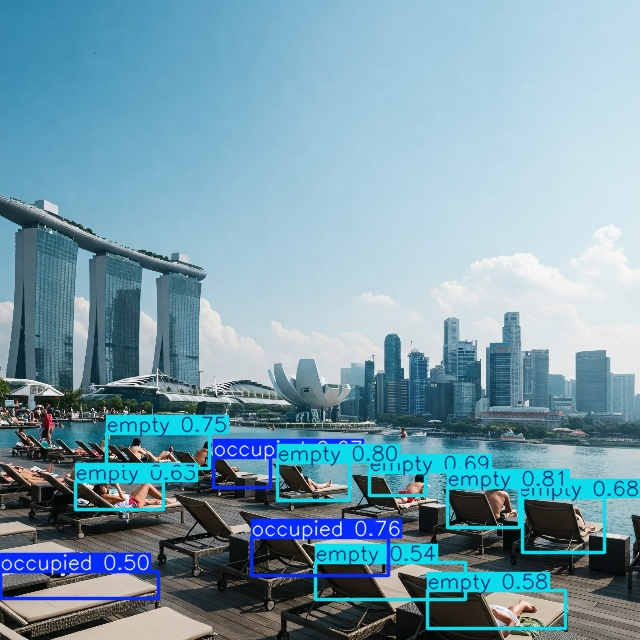

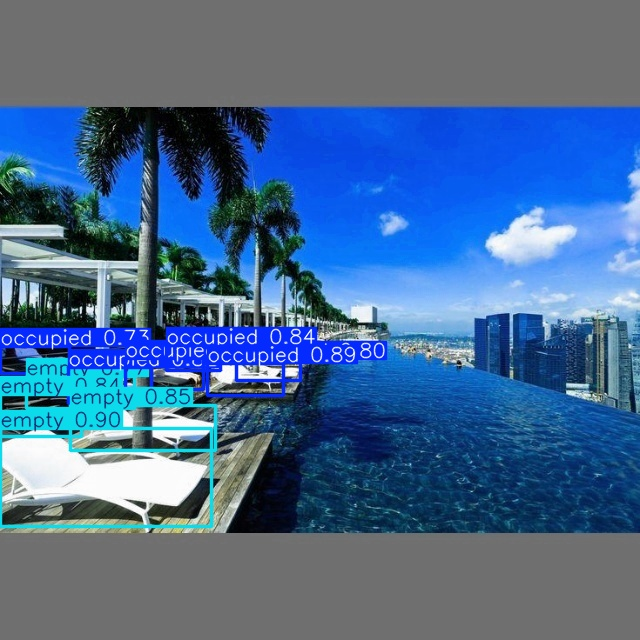

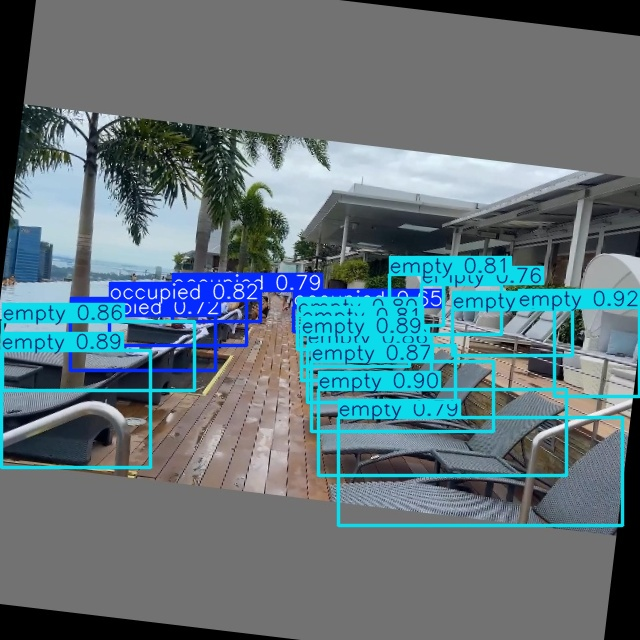

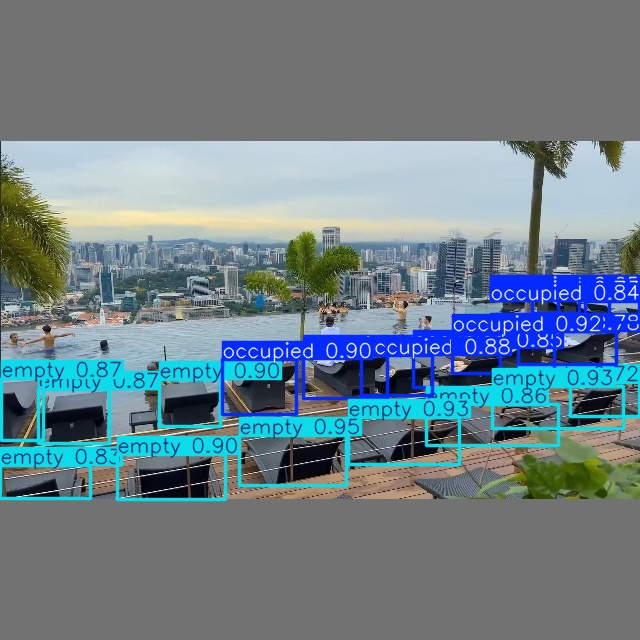

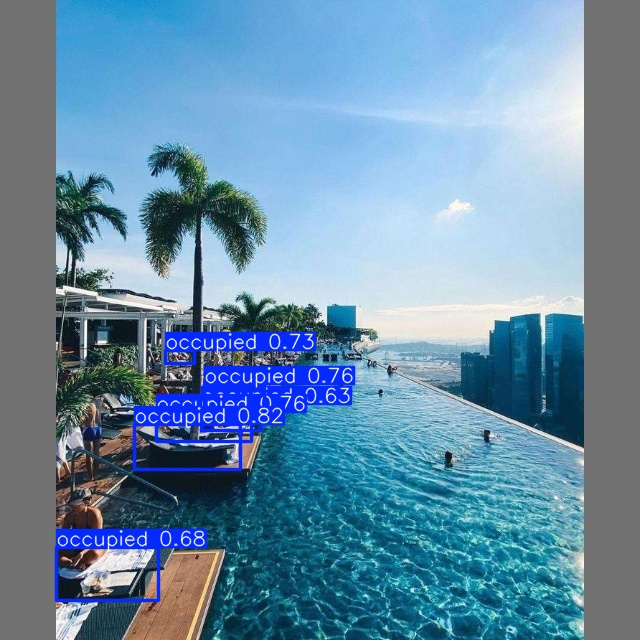

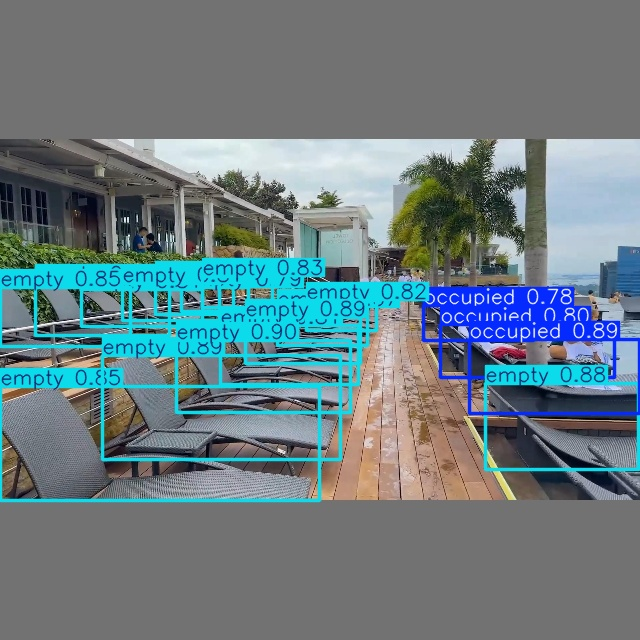

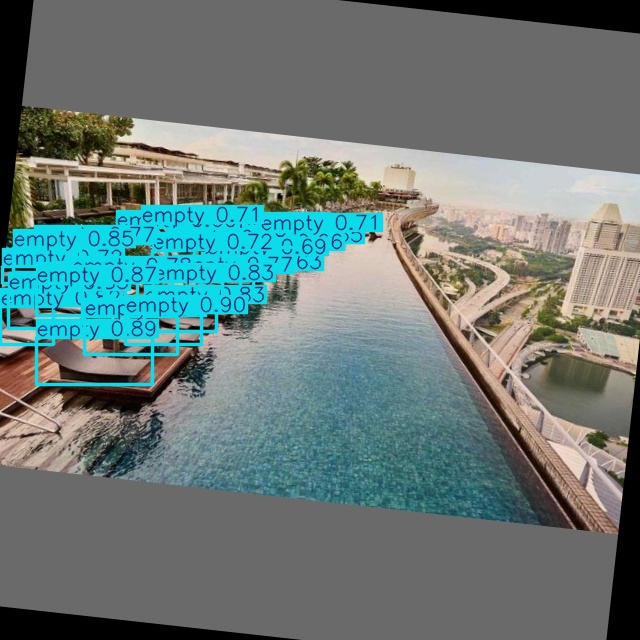

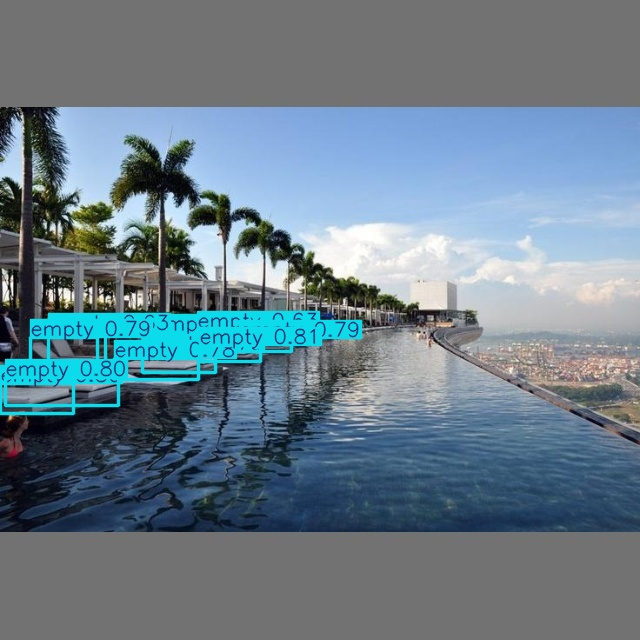

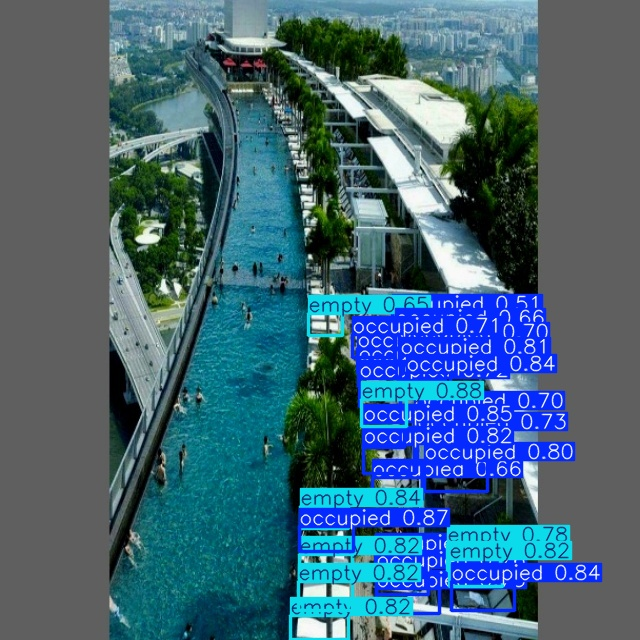

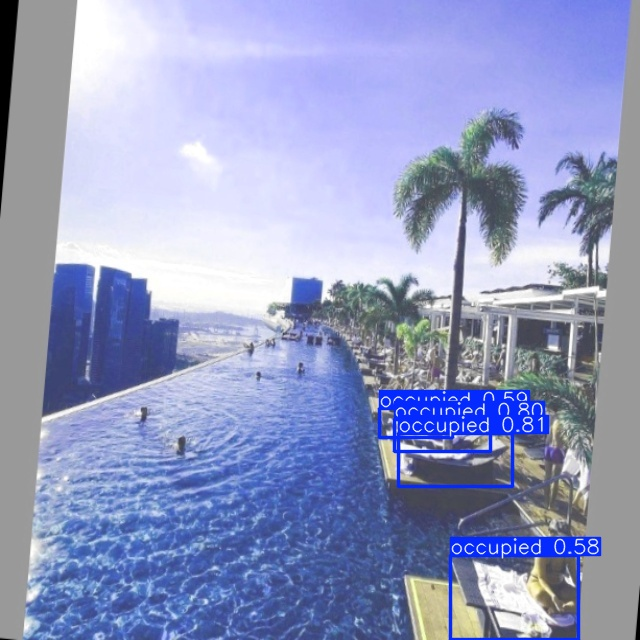

In [15]:
from ultralytics import YOLO
model_path = "/content/model/train/weights/best.pt"
# Load your trained YOLO model
# model = YOLO("/content/model/model.pt")  # Update the path if needed
model = YOLO(model_path)
test_image_path = "data/validation/images"

# Threshold CONFIGURATIONS
INFERENCE = config["INFERENCE"]
CONF_THRESHOLD = INFERENCE["CONF_THRESHOLD"]
IOU_THRESHOLD  = INFERENCE["IOU_THRESHOLD"]

# Run predict on images in a folder, use the variables from config if desired
results = model.predict(source=test_image_path, conf=0.5, iou=0.5, save=True)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


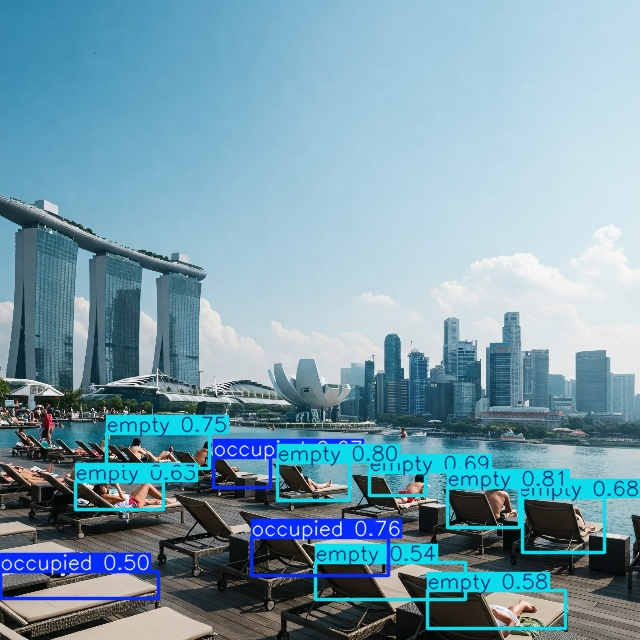

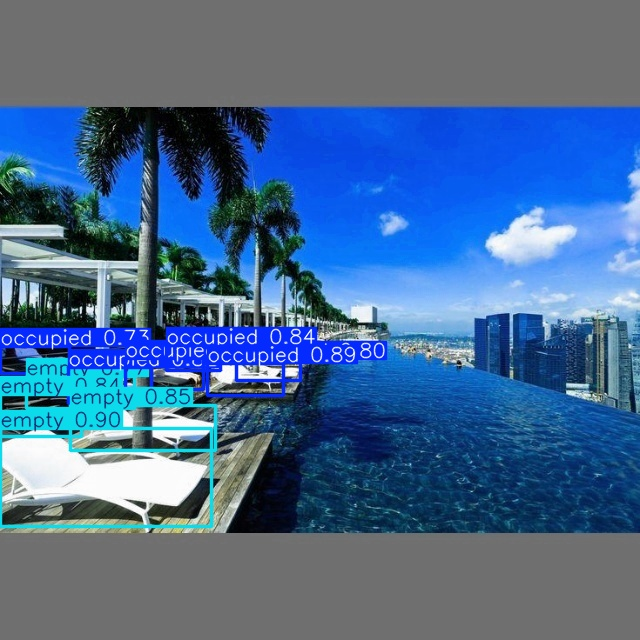

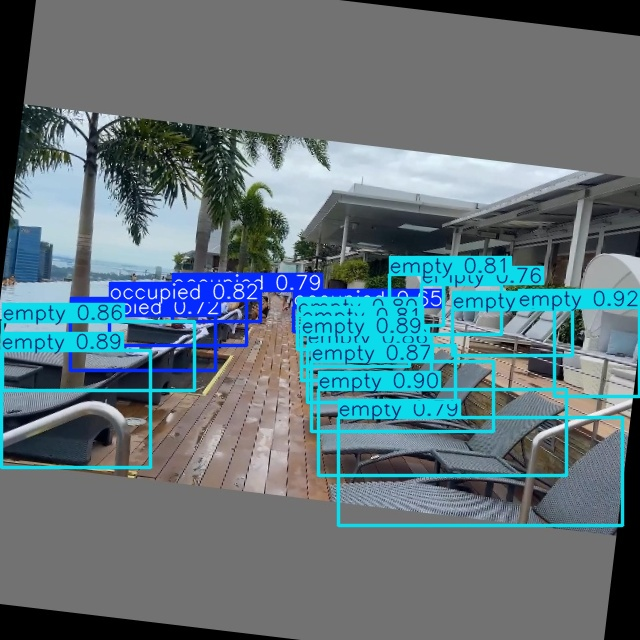

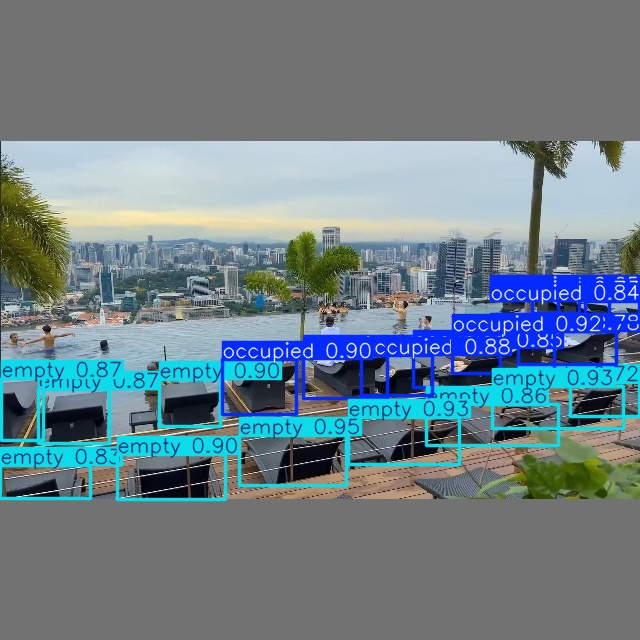

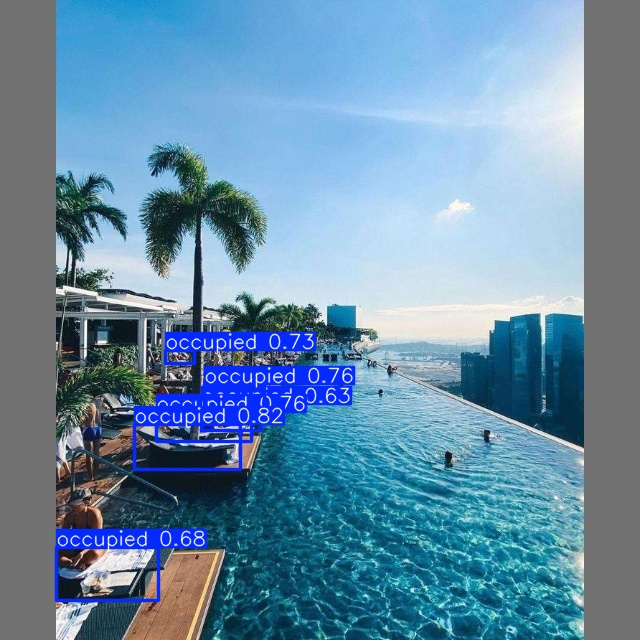

In [16]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:5]:
  display(Image(filename=image_path, height=400))
  print('\n')


# Video predict

In [ ]:
from src.scripts.inference import load_model, run_inference_on_video

video_path = "video_path"

run_inference_on_video(model, video_path, conf_threshold=CONF_THRESHOLD, imgsz=640)
